Group Members:
*   Bertone Giorgio: 2112729
*   Brigandi Camilla: 2055650

# Task 1

### Import all libraries

In [ ]:
!pip install -q sentence_transformers
import json
import requests
import pandas as pd
import gzip
from gensim.models import Word2Vec
from gensim.models import FastText
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sentence_transformers.util import cos_sim
import numpy as np
import re
from sklearn.model_selection import train_test_split
import zipfile
import os
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import gensim.downloader as api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Download the file

We are going to use the **Gift_Cards** review dataset, containing 152.4K reviews.

In [ ]:
# Function to download and save the JSON file
def download_json(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        print("File downloaded successfully.")
    else:
        print("Failed to download the file.")


# Download reviews
url = "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Gift_Cards.jsonl.gz" # URL of the JSON file to download
filename = "reviews.jsonl" # Define the filename to save the downloaded JSON file
download_json(url, filename) # Download and save the JSON file

File downloaded successfully.


In [ ]:
filename = "reviews.jsonl"
with gzip.open(filename, 'rt', encoding='utf-8') as f:
    df_reviews = pd.read_json(f, lines=True)

In [ ]:
df_reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Great gift,Having Amazon money is always good.,[],B00IX1I3G6,B00IX1I3G6,AHZ6XMOLEWA67S3TX7IWEXXGWSOA,2019-02-11 06:22:38.332,0,True
1,5,amazon gift card,Always the perfect gift. I have never given o...,[],B005ESMMWW,B005ESMMWW,AFZUK3MTBIBEDQOPAK3OATUOUKLA,2020-09-12 01:45:58.120,0,False
2,5,perfect gift,When you have a person who is hard to shop for...,[],B01K8RIM5Y,B005S28ZES,AFZUK3MTBIBEDQOPAK3OATUOUKLA,2018-09-03 01:58:49.239,27,True
3,5,Nice looking,The tin is a nice touch and pretty large. It'...,[],B0091JKVU0,B00ADR2LV6,AFZUK3MTBIBEDQOPAK3OATUOUKLA,2014-12-13 02:59:37.000,0,False
4,1,Not $10 Gift Cards,I bought this pack of Starbucks Gift cards in ...,[],B00FTGTM5E,B00FTGTIOE,AH5L7ILVA6HYLZOUZIQAWNHVVK3A,2021-11-28 03:06:48.115,2,True


In [ ]:
df_reviews.shape

(152410, 10)

We want to do clean the data by removing remove useless reviews made up by only characters not conveying any meaning.

In [ ]:
# Trim whitespace from the 'text' column
df_reviews['text'] = df_reviews['text'].str.strip()

undesired_texts = [
    '', ' ', '\t', '\n', '!', '.', '?', ',', '-', '_', '*', '&', '#', '@', '$', '%', '^',
    '(', ')', '{', '}', '[', ']', ':', ';', '"', "'", 'N/A',]

# Filter out rows with undesired text values
df_reviews_clean = df_reviews[~df_reviews['text'].isin(undesired_texts)]

We take a look at the class distribution to see if the dataset is balanced.

In [ ]:
print('Positve reviews: ', len(df_reviews_clean[df_reviews_clean['rating'].isin([3, 4, 5])]))

Positve reviews:  138127


In [ ]:
print('Negative reviews: ', len(df_reviews_clean[df_reviews_clean['rating'].isin([1, 2])]))

Negative reviews:  14177


The dataset is, in fact, very unbalanced. We are going to improve this slightly by only considering a subset of the positive reviews.

In [ ]:
# Filter the dataset to keep only the instances where the rating is 3, 4, or 5
filtered_df_pos = df_reviews_clean[df_reviews_clean['rating'].isin([3, 4, 5])]

# Limit the positive dataset to 100,000 instances
filtered_df_pos = filtered_df_pos.sample(n=100_000, random_state=42)

# Filter the dataset to keep only the instances where the rating is 1 or 2
filtered_df_neg = df_reviews_clean[df_reviews_clean['rating'].isin([1, 2])]

# Concatenate the two datasets
combined_df = pd.concat([filtered_df_pos, filtered_df_neg], ignore_index=True)

### Create embeddings

We want to embed the words into vectors in order to capture information about the meaning meaning of the words, their *semantic* meaning, and represent this numerically. This will allow us also to perform mathematical operations on them.

#### Process the text

Before creating the embeddings we need to preprocess the text in order to improve the quality of embeddings. Moreover,  we will split the data while maintaining the proportion of the minority class across training, validation, and test sets, ensuring it is meaningfully represented in each subset. Then, we will train our embedding models only on the combined train and validation data, as including the test data would give us more information on the meaning of the word than we actually would have in a real-world scenario where we don't have the test data beforehand.

In [ ]:
reviews = combined_df[['rating', 'text']]
print('Shape:', reviews.shape)

Shape: (114177, 2)


In [ ]:
# Function to preprocess the text
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

     # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [ ]:
# Convert ratings: < 3 to 0 (Negative) and >= 3 to 1 (Positive)
reviews.loc[:, 'label'] = reviews['rating'].apply(lambda x: 0 if x < 3 else 1)

# Split the data into train, validation, and test sets with stratification to keep portion of minority class constant
train_reviews, temp_reviews = train_test_split(reviews, test_size=0.2, stratify=reviews['label'], random_state=13)
val_reviews, test_reviews = train_test_split(temp_reviews, test_size=0.5, stratify=temp_reviews['label'], random_state=13)

<ipython-input-71-7d6b9b4627be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.loc[:, 'label'] = reviews['rating'].apply(lambda x: 0 if x < 3 else 1)


In [ ]:
# Tokenize the text data into lists of words
tokenized_text_tr = train_reviews['text'].apply(preprocess_text)
train_reviews.loc[:, 'tokens'] = tokenized_text_tr

tokenized_text_val = val_reviews['text'].apply(preprocess_text)
val_reviews.loc[:, 'tokens'] = tokenized_text_val

tokenized_text_te = test_reviews['text'].apply(preprocess_text)
test_reviews.loc[:,'tokens'] = tokenized_text_te

In [ ]:
train_reviews.head()

,rating,text,label,tokens
89655,5,I like this version of the Amazon gift card be...,1,"[like, version, amazon, gift, card, attractive..."
58584,5,gifts,1,[gift]
48104,5,Good gift,1,"[good, gift]"
81849,5,Wonderful present,1,"[wonderful, present]"
106994,1,Product was is useless if you can notice it to...,0,"[product, useless, notice, gaming, site, use, ..."


In [ ]:
# Join the train and validation data in a single column
train_val_reviews = pd.concat([train_reviews, val_reviews])
tokenized_text_tr_val = train_val_reviews['tokens']

In [ ]:
tokenized_text_tr_val

89655     [like, version, amazon, gift, card, attractive...
58584                                                [gift]
48104                                          [good, gift]
81849                                  [wonderful, present]
106994    [product, useless, notice, gaming, site, use, ...
                                ...                        
84639     [disliked, gift, card, amount, card, card, lov...
28660     [mean, gift, card, bad, however, product, desc...
37112                                       [helpful, love]
59159                     [easy, use, used, multiple, time]
12813                         [love, free, box, gift, card]
Name: tokens, Length: 102759, dtype: object

#### 1.**Word2vec**

The primary idea behind Word2Vec is to learn distributed representations of words based on their context in a large corpus of text by using a neural network. There are two main architectures: CBOW and Skip-gram. In the CBOW model we combine the representations of surrounidng words to predict the one in the middle, in the Skip-gram the representation of the input word is used to predict the context.

In [ ]:
# Train Word2Vec model
model_word2vec = Word2Vec(tokenized_text_tr_val, min_count=2, vector_size = 200,
                          window = 5, sg=1, seed=13) # setting sg=1 we use the skipgram

We also want to have the possibility to handle unknown tokens, thus we add a vector for unknown tokens, represented as `<UNK>`, and initialize it to be the average of all vectors. By doing so we aim to achieve a representation for the unknow words that is not biased towards any particular word or concept.

In [ ]:
unk_token = '<UNK>'
if unk_token not in model_word2vec.wv:
    # Initialize <UNK> embedding as mean of all embeddings
    mean_embedding = np.mean(model_word2vec.wv.vectors, axis=0)
    model_word2vec.wv.add_vector(unk_token, mean_embedding)


/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [ ]:
# Get word vector for a word
model_word2vec.wv['card'].shape

(200,)

In [ ]:
print("Similarity between 'good' and 'great':", model_word2vec.wv.similarity('good', 'great'))
print("Similarity between 'good' and 'bad':", model_word2vec.wv.similarity('good', 'bad'))
print("\nSimilarity between 'car' and 'bike':", model_word2vec.wv.similarity('car', 'bike'))
print("Similarity between 'drive' and 'ride':", model_word2vec.wv.similarity('drive', 'ride'))
print("\nDistance between 'girl' and 'boy':", model_word2vec.wv.distance('girl', 'boy'))
print("Distance between 'woman' and 'man':", model_word2vec.wv.distance('woman', 'man'))

Similarity between 'good' and 'great': 0.7646202
Similarity between 'good' and 'bad': 0.5465617

Similarity between 'car' and 'bike': 0.68013465
Similarity between 'drive' and 'ride': 0.63872534

Distance between 'girl' and 'boy': 0.12642914056777954
Distance between 'woman' and 'man': 0.2840493321418762


The high similarity score indicates that 'good' and 'great' are closely related in meaning, which is correct. Although 'good' and 'bad' are antonyms, the similarity score is moderate, but this makes sense, because they often appear in similar contexts and are both adjectives. The similarity between 'bike' and 'car' is very close to the similarity between 'ride' and 'drive', and they both are high as they have related meaning. The low distance score indicates that 'girl' and 'boy' are very close in the embedding space, reflecting their close relationship. The close distances between gender-specific terms reflects the embeddings' ability to accurately represent closely related concepts.

In [ ]:
w1 = "bad"
w2 = "good"
w3 = "card"

print("Most similar to", w1, ": ", model_word2vec.wv.most_similar(w1))
print("Most similar to", w2, ": ", model_word2vec.wv.most_similar(w2))
print("Most similar to", w3, ": ", model_word2vec.wv.most_similar(w3))

Most similar to bad :  [('negative', 0.7007301449775696), ('horrible', 0.6849042773246765), ('mouth', 0.6824060082435608), ('agree', 0.6814503073692322), ('scared', 0.6783797144889832), ('skeptical', 0.6718047857284546), ('nervous', 0.6684934496879578), ('based', 0.6635424494743347), ('lucky', 0.6597937941551208), ('dumb', 0.6585529446601868)]
Most similar to good :  [('great', 0.7646201848983765), ('flash', 0.7120118737220764), ('excellent', 0.7053967714309692), ('awesome', 0.6929025650024414), ('fantastic', 0.6910639405250549), ('reasonable', 0.6827701330184937), ('decent', 0.6816257834434509), ('greatbr', 0.6805847883224487), ('terrific', 0.6747010350227356), ('pleasant', 0.6744771003723145)]
Most similar to card :  [('gc', 0.7555807828903198), ('certificate', 0.75404292345047), ('cardand', 0.7339584231376648), ('cardit', 0.7310400009155273), ('monetary', 0.7210921049118042), ('preloaded', 0.7182334661483765), ('git', 0.7149972915649414), ('cardthe', 0.7072809338569641), ('giftcards

The most similar words to some words we chose are reasonable.

#### 2.**FastText**

The second embedding model we are going to use is FastText, an extension of the Word2Vec model. While Word2Vec operates at the word level, FastText operates at the sub-word level, allowing it to capture morphological information and handle out-of-vocabulary words more effectively.

In [ ]:
# Train FastText model
model_fasttext = FastText(tokenized_text_tr_val, min_count=2, vector_size = 200,
                          window = 5, sg=1, seed=13)

In [ ]:
# Get word vector for a word
model_fasttext.wv['card'].shape

(200,)

In [ ]:
print("Similarity between 'good' and 'great':", model_fasttext.wv.similarity('good', 'great'))
print("Similarity between 'good' and 'bad':", model_fasttext.wv.similarity('good', 'bad'))
print("Similarity between 'person' and 'card':", model_fasttext.wv.similarity('person', 'card'))

Similarity between 'good' and 'great': 0.79493296
Similarity between 'good' and 'bad': 0.60108787
Similarity between 'person' and 'card': 0.50870305


In [ ]:
print("Similarity between same words with different embedding technique:", cos_sim(model_fasttext.wv["good"], model_word2vec.wv["good"]))

Similarity between same words with different embedding technique: tensor([[0.2261]])


The vector embeddings of the same word for the two models are very different, this will guide our choice in how to combine all the embeddings later on.

In [ ]:
w1 = "bad"
w2 = "good"
w3 = "card"

print("Most similar to", w1, ": ", model_fasttext.wv.most_similar(w1))
print("Most similar to", w2, ": ", model_fasttext.wv.most_similar(w2))
print("Most similar to", w3, ": ", model_fasttext.wv.most_similar(w3))

Most similar to bad :  [('sad', 0.7556607723236084), ('honesty', 0.7338019013404846), ('faultwe', 0.7330501079559326), ('badge', 0.7273802161216736), ('unscrupulous', 0.7264896035194397), ('dubious', 0.7227024435997009), ('territory', 0.7207419872283936), ('faulty', 0.7199122905731201), ('horribly', 0.717203676700592), ('faux', 0.7155852317810059)]
Most similar to good :  [('goodi', 0.932860255241394), ('goood', 0.8954263925552368), ('goodie', 0.8784317970275879), ('goodbut', 0.8612499833106995), ('yougood', 0.8610261678695679), ('goodbye', 0.8606805205345154), ('goo', 0.8576775789260864), ('gooood', 0.8568106889724731), ('goody', 0.8551977872848511), ('34good', 0.8526505827903748)]
Most similar to card :  [('card0', 0.9407387375831604), ('cardi', 0.9318283200263977), ('cardif', 0.9265337586402893), ('carddid', 0.9253924489021301), ('cardit', 0.9228317737579346), ('cardits', 0.9136900305747986), ('cardsi', 0.9045307636260986), ('cardso', 0.9020347595214844), ('cardyou', 0.8990333676338

In [ ]:
model_fasttext.wv.most_similar(positive=['good', 'buy'])

[('goood', 0.897330105304718),
 ('goodi', 0.890021026134491),
 ('gooood', 0.8804044723510742),
 ('goody', 0.8707549571990967),
 ('goodbut', 0.8653651475906372),
 ('goodbye', 0.8653278350830078),
 ('goo', 0.8651828169822693),
 ('goodie', 0.8627898097038269),
 ('goooood', 0.8486794233322144),
 ('tobuy', 0.8437478542327881)]

Also for FastText the results seem reasonable

#### 3.**Glove**

GloVe (Global Vectors for Word Representation) unlike Word2Vec directly models the co-occurrence statistics of words in a corpus to learn word embeddings. We are not going to train this model but to simply download a pre-trained one.

In [ ]:
glove_index = api.load("glove-twitter-200")

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
# Save embeddings_index to Drive
#drive_path = '/content/drive/My Drive/embeddings_index.pkl'
#with open(drive_path, 'wb') as f:
#    pickle.dump(glove_index, f)

In [ ]:
# Load embeddings_index from Drive
drive_path = '/content/drive/My Drive/embeddings_index.pkl'
with open(drive_path, 'rb') as f:
    glove_index = pickle.load(f)
print(f'Loaded')

Loaded


In [ ]:
# Get the embedding for the word "card"
word = 'card'
glove_vector = glove_index[word]
print(f'Embedding size for "{word}":\n{len(glove_vector)}')

Embedding size for "card":
200


In [ ]:
word = "good"

# Print cosine similarities
print(f'Cosine similarity between GloVe and FastText for "{word}": {cos_sim(glove_index[word], model_fasttext.wv[word])}')
print(f'Cosine similarity between GloVe and Word2Vec for "{word}": {cos_sim(glove_index[word], model_word2vec.wv[word])}')

Cosine similarity between GloVe and FastText for "good": tensor([[0.0417]])
Cosine similarity between GloVe and Word2Vec for "good": tensor([[0.1377]])


In [ ]:
print(f'Cosine similarity between "good" and "card": {cos_sim(glove_index["good"], glove_index["card"])}')
print(f'Cosine similarity between "good" and "great": {cos_sim(glove_index["good"], glove_index["great"])}')

Cosine similarity between "good" and "card": tensor([[0.4468]])
Cosine similarity between "good" and "great": tensor([[0.8673]])


In [ ]:
if unk_token not in glove_index:
    # Initialize <UNK> embedding as mean of all vectors
    glove_index[unk_token]=np.mean(glove_index.vectors, axis=0)

#### From word to sentence embeddings

To guide our choices in deciding what approach to follow to move from word to sentence embeddings we referred to the following answers [link 1](https://stackoverflow.com/questions/63779875/sentences-embedding-using-word2vec), [link 2](https://stackoverflow.com/questions/49656630/converting-a-sentence-to-an-embedding-representation), [link 3](https://datascience.stackexchange.com/questions/110718/sum-vs-mean-of-word-embeddings-for-sentence-similarity).

In [ ]:
# Define a function to get the sentence vector for word2vec and fasttext
def get_sentence_vector(tokens, model):
    valid = [word for word in tokens if word in model.wv.key_to_index]
    if not valid:
        return np.zeros(model.vector_size)
    word_vectors = [model.wv[word] for word in valid]
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

# Define a function to get the sentence vector for glove
def get_sentence_vector_glove(tokens, model):
    valid = [word for word in tokens if word in model.key_to_index]
    if not valid:
        return np.zeros(model.vector_size)
    word_vectors = [model[word] for word in valid]
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

# Convert each sentence in the dataset to a vector using word2vec embeddings
train_reviews.loc[:, 'w2v_vector'] = train_reviews['tokens'].apply(lambda tokens: get_sentence_vector(tokens, model_word2vec))
val_reviews.loc[:, 'w2v_vector'] = val_reviews['tokens'].apply(lambda tokens: get_sentence_vector(tokens, model_word2vec))

# Convert each sentence in the dataset to a vector using fasttext embeddings
train_reviews.loc[:, 'ft_vector'] = train_reviews['tokens'].apply(lambda tokens: get_sentence_vector(tokens, model_fasttext))
val_reviews.loc[:, 'ft_vector'] = val_reviews['tokens'].apply(lambda tokens: get_sentence_vector(tokens, model_fasttext))

# Convert each sentence in the dataset to a vector using glove embeddings
train_reviews.loc[:, 'glove_vector'] = train_reviews['tokens'].apply(lambda tokens: get_sentence_vector_glove(tokens, glove_index))
val_reviews.loc[:, 'glove_vector'] = val_reviews['tokens'].apply(lambda tokens: get_sentence_vector_glove(tokens, glove_index))

#### Combine the embeddings

In [ ]:
embs_train = train_reviews[['w2v_vector', 'ft_vector', 'glove_vector']]
embs_val = val_reviews[['w2v_vector', 'ft_vector', 'glove_vector']]
embs_train.head()

,w2v_vector,ft_vector,glove_vector
89655,"[0.08752123, 0.0070203375, 0.15611759, -0.0797...","[0.3719331, 0.23434919, 0.08336111, 0.13852002...","[-0.12017343, -0.0043653115, -0.019309659, 0.2..."
58584,"[0.09764589, -0.118717864, 0.31163332, 0.00342...","[0.60043764, 0.32414815, 0.032305725, 0.235752...","[-0.22078, -0.054201, 0.11548, 0.4474, 0.91388..."
48104,"[-0.013963088, 0.050430544, 0.206994, -0.10655...","[0.42439008, 0.18354064, 0.03316942, -0.019053...","[-0.1012785, -0.033262, 0.0755245, 0.34486002,..."
81849,"[-0.05102025, 0.012834533, 0.4045667, 0.014615...","[0.48349744, -0.0064234007, 0.13730332, 0.0134...","[0.29969, -0.1109, 0.12054001, 0.24170001, 0.2..."
106994,"[0.062054526, 0.003676829, 0.051277027, -0.122...","[0.08128247, 0.21251848, 0.06315768, -0.001335...","[0.046377644, 0.216292, -0.25054562, 0.0111306..."


We combine the embeddings by simply concatenating them as the results of the various models are very different vectors for the same word.

In [ ]:
def combine_embeddings(row):
    combined_embedding = np.concatenate([row['w2v_vector'], row['ft_vector'], row['glove_vector']])
    return combined_embedding

# Apply the function to each row
embs_train.loc[:, 'combined_embedding'] = embs_train.apply(combine_embeddings, axis=1)
embs_val.loc[:, 'combined_embedding'] = embs_val.apply(combine_embeddings, axis=1)

<ipython-input-90-e45d0bc60c2e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embs_train.loc[:, 'combined_embedding'] = embs_train.apply(combine_embeddings, axis=1)
<ipython-input-90-e45d0bc60c2e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embs_val.loc[:, 'combined_embedding'] = embs_val.apply(combine_embeddings, axis=1)


In [ ]:
embs_train['combined_embedding'].head()

89655     [0.08752123, 0.0070203375, 0.15611759, -0.0797...
58584     [0.09764589, -0.118717864, 0.31163332, 0.00342...
48104     [-0.013963088, 0.050430544, 0.206994, -0.10655...
81849     [-0.05102025, 0.012834533, 0.4045667, 0.014615...
106994    [0.062054526, 0.003676829, 0.051277027, -0.122...
Name: combined_embedding, dtype: object

In [ ]:
print(len(embs_train['combined_embedding'].iloc[0]))
print(len(embs_val['combined_embedding'].iloc[0]))

600
600


In [ ]:
train_reviews['combined_embedding'] = embs_train['combined_embedding']
val_reviews['combined_embedding'] = embs_val['combined_embedding']

### LSTM

We will now implement a Long Short-Term Memory (LSTM), a type of Recurrent Neural Network (RNN) developed to deal with the exploding/vanishing gradient problem of RNN. This allows them to learn also long-term dependencies and makes them very useful at handling sequential data.

#### Import libraries

In [ ]:
!pip install -q pytorch_lightning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split, TensorDataset
from pytorch_lightning import Trainer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, balanced_accuracy_score
import torchmetrics

#### Create LSTM Cell

We first create the cell of the LSTM model, setting up the cell state which acts as the LSTM's long-term memory, carrying information across time steps. Then we also set up the forget gate, input gate, and output gate, which act as control mechanisms. In particular they determine which percentage of the long-term memory will be remembered, what new information to store in the cell state and what information from the current cell gets passed on to the next cell in the sequence.

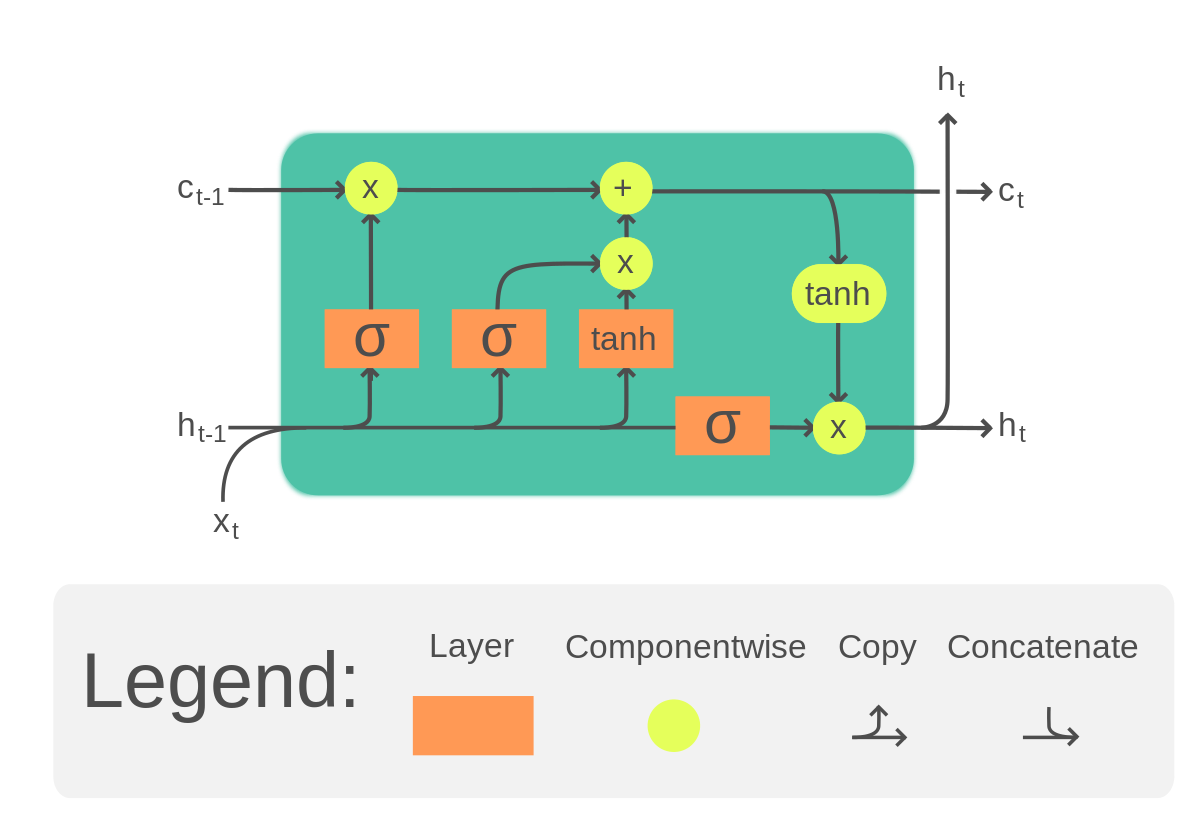

In [ ]:
class myLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_state_size):
        super(myLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_state_size = hidden_state_size

        # Input linear transformations --- dimension input_size x hidden_state_size
        self.forget_gate_x = nn.Linear(input_size, hidden_state_size) # output = U_f * x_(t - 1) + b_f
        self.input_gate_x = nn.Linear(input_size, hidden_state_size)
        self.output_gate_x = nn.Linear(input_size, hidden_state_size)
        self.cell_gate_x = nn.Linear(input_size, hidden_state_size)

        # Hidden state linear transformations --- dimension input_size x hidden_state_size
        self.forget_gate_h = nn.Linear(hidden_state_size, hidden_state_size)  #output = W_f * h_(t - 1) + b_f
        self.input_gate_h = nn.Linear(hidden_state_size, hidden_state_size)
        self.output_gate_h = nn.Linear(hidden_state_size, hidden_state_size)
        self.cell_gate_h = nn.Linear(hidden_state_size, hidden_state_size)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param.data, mean=0.0, std=1.0)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

    def forward(self, input, prev_state):

        # Unpack previous state
        h_prev, c_prev = prev_state

        # Forget gate
        forget_gate = torch.sigmoid(self.forget_gate_h(h_prev) + self.forget_gate_x(input))
        # Input gate
        input_gate = torch.sigmoid(self.input_gate_h(h_prev) + self.input_gate_x(input))
        # Output gate
        output_gate = torch.sigmoid(self.output_gate_h(h_prev) + self.output_gate_x(input))
        # Cell gate
        cell_gate = torch.tanh(self.cell_gate_h(h_prev) + self.cell_gate_x(input)) # new content

        # Update cell
        c_next = forget_gate * c_prev + input_gate * cell_gate

        # Update hidden state
        h_next = output_gate * torch.tanh(c_next)

        return c_next, h_next

We run a basic test to verify the LSTM cell can process inputs and produce outputs.

In [ ]:
# Create LSTM cell
input_size = 1
hidden_size = 1
lstm_cell = myLSTMCell(input_size, hidden_size)

# Define a test input and initial states
test_input = torch.randn(1, input_size)  # batch_size = 1
h_prev = torch.randn(1, hidden_size)
c_prev = torch.randn(1, hidden_size)

# Run the LSTM cell
c_next, h_next = lstm_cell(test_input, (h_prev, c_prev))

print("Input:", test_input)
print("Previous Hidden State:", h_prev)
print("Previous Cell State:", c_prev)
print("Next Hidden State:", h_next)
print("Next Cell State:", c_next)

Input: tensor([[-0.6718]])
Previous Hidden State: tensor([[0.3105]])
Previous Cell State: tensor([[-1.0387]])
Next Hidden State: tensor([[-0.2505]], grad_fn=<MulBackward0>)
Next Cell State: tensor([[-0.3500]], grad_fn=<AddBackward0>)


#### Create the model

We then create the model by stacking several cells together and "*connecting*" them with a forward loop mechanism. Finally, we use **PyTorch Lightning** to simplify the training process.

In [ ]:
class myLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_state_size, output_size):
        super(myLSTMModel, self).__init__()

        self.hidden_state_size = hidden_state_size

        # Create the LSTM cell
        self.lstm_cell = myLSTMCell(input_size, hidden_state_size)

        # Hidden to output layer transformation
        self.hidden_to_out = nn.Linear(hidden_state_size, output_size) # W_out * h_final + b_out

        # Initialize the weights of last layer
        nn.init.normal_(self.hidden_to_out.weight)
        nn.init.zeros_(self.hidden_to_out.bias)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        # Initialize hidden and cell states
        h = torch.zeros(batch_size, self.hidden_state_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_state_size).to(x.device)

        # Loop over sequence length
        for t in range(seq_len):
            x_t = x[:, t, :]
            # Forward pass through the LSTM cell
            h, c = self.lstm_cell(x_t, (h, c))

        # Compute final output
        out = self.hidden_to_out(h)
        # Apply softmax activation
        out = F.softmax(out, dim=1)
        return out


class myLSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_state_size, output_size, learning_rate=1e-3):
        super(myLSTM, self).__init__()
        self.model = myLSTMModel(input_size, hidden_state_size, output_size)
        self.learning_rate = learning_rate

        # Define which loss function to use
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize lists to store losses for plotting
        self.train_losses = []
        self.val_losses = []

        # Initialize accuracy metrics
        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=output_size)
        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=output_size)
        self.train_acc = []
        self.val_acc = []

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)

        # Compute and save training loss
        loss = self.loss_fn(y_pred, y)
        self.train_losses.append(loss.item())
        self.log('train_loss', loss, on_epoch=True)

        # Compute and save accuracy
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_accuracy(preds, y)
        self.train_acc.append(acc)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)

        # Compute and save validation loss
        loss = self.loss_fn(y_pred, y)
        self.val_losses.append(loss.item())
        self.log('val_loss', loss, on_epoch=True)

        # Compute and save accuracy
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_accuracy(preds, y)
        self.val_acc.append(acc)

        return loss


#### Training the model

We define a custom dataset class to pass to the model to allow for efficient memory management and loading data in batches.

In [ ]:
# Get train and validation data
train_data = train_reviews[['label', 'combined_embedding']]
val_data =  val_reviews[['label', 'combined_embedding']]

# Custom Dataset class
class ReviewDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.vectors = list(data['combined_embedding'])
        self.labels = list(data['label'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        vector = torch.tensor(self.vectors[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        # Add a sequence dimension
        vector = vector.unsqueeze(0)  # (input_size) -> (1, input_size)
        return vector, label

# Create DataLoader for training and validation sets
train_dataset = ReviewDataset(train_data)
val_dataset = ReviewDataset(val_data)

BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Training the model
input_size = len(train_data.iloc[:, 1].iloc[0])  # Size of embedding vectors
hidden_size = 128  # Hidden size of the LSTM
output_size = 2  # Number of output classes (positive, negative)

model = myLSTM(input_size, hidden_size, output_size)

# Callback for saving the best model
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=3, mode='min')

# Initialize the Trainer
epochs = 15
trainer = pl.Trainer(max_epochs=epochs, callbacks=[checkpoint_callback])

# Train the model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | model          | myLSTMModel        | 374 K 
1 | loss_fn        | CrossEntropyLoss   | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
------------------------------------------------------
374 K     Trainable params
0         Non-trainable params
374 K     Total params
1.496     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


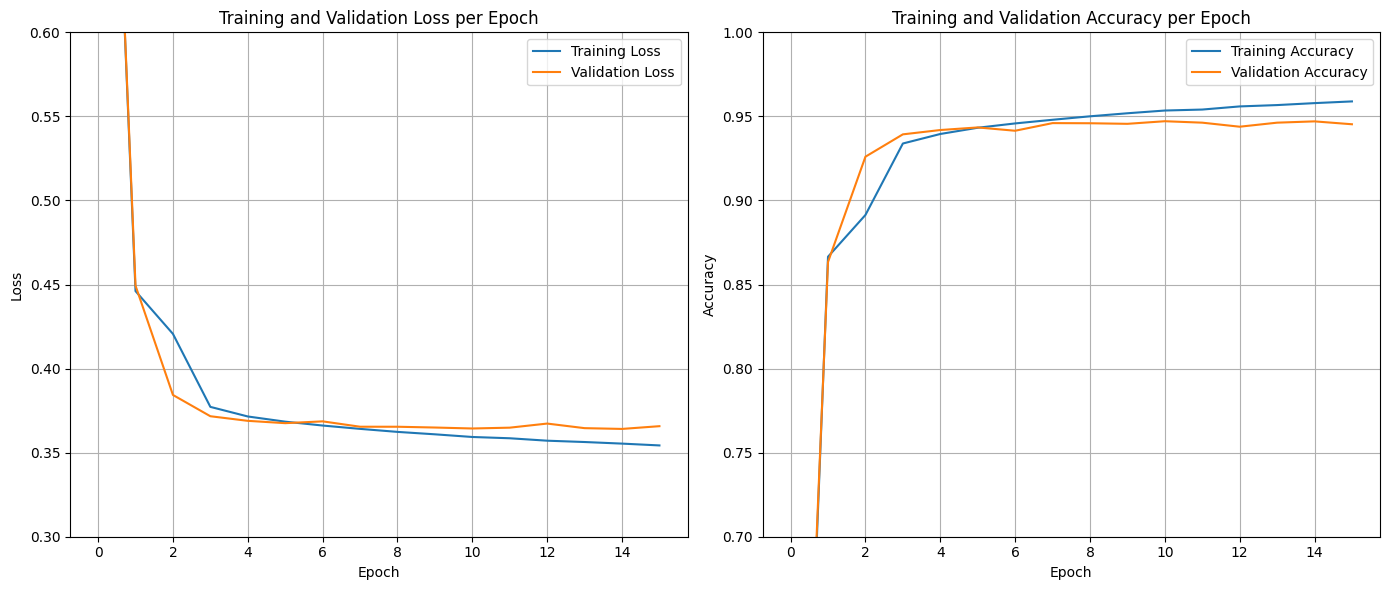

In [ ]:
# Compute the number of observations in total
e_t = len(train_loader)*epochs
e_v = len(val_loader)*epochs

# Initialize lists to hold epoch losses
epoch_train_losses = []
epoch_val_losses = []

# Initialize lists to hold epoch accuracy
epoch_train_acc = []
epoch_val_acc = []

# Compute epoch training losses
start = 0
for i in range(0, e_t+1, len(train_loader)):
    epoch_train_losses.append(np.mean(model.train_losses[start:i+1]))
    train_acc_cpu = [acc.cpu().numpy() for acc in model.train_acc[start:i+1]]
    epoch_train_acc.append(np.mean(train_acc_cpu))
    start = i

# Compute epoch validation losses
start = 0
for i in range(0, e_v+1, len(val_loader)):
    epoch_val_losses.append(np.mean(model.val_losses[start:i+1]))
    val_acc_cpu = [acc.cpu().numpy() for acc in model.val_acc[start:i+1]]
    epoch_val_acc.append(np.mean(val_acc_cpu))
    start = i

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot losses
axs[0].plot(epoch_train_losses, label='Training Loss')
axs[0].plot(epoch_val_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss per Epoch')
axs[0].legend()
axs[0].grid(True)
axs[0].set_ylim(0.3, 0.6)

# Plot accuracies
axs[1].plot(epoch_train_acc, label='Training Accuracy')
axs[1].plot(epoch_val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy per Epoch')
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim(0.7, 1)

plt.tight_layout()
plt.show()

We notice that the model converges pretty quickly and that as the number of epochs increases the training and validation loss start to diverge, an indication that the model might start to overfit (same for accuracy).

We are now interested in testing if our model works on a made up review we create

In [ ]:
sentence = """The delivery was late, I am disappointed by amazon"""
# Tokenize the sentence
tokens = preprocess_text(sentence)

# Convert each token to vector
word_vectors_w2v = []
word_vectors_ft = []
word_vectors_glove = []

for token in tokens:
    word_vector = model_fasttext.wv[token]
    word_vectors_ft.append(word_vector)

    if token in model_word2vec.wv:
        word_vector = model_word2vec.wv[token]
        word_vectors_w2v.append(word_vector)
    else:
        # Handle oov words using <UNK> token
        word_vector = model_word2vec.wv['<UNK>']
        word_vectors_w2v.append(word_vector)

    if token in glove_index:
        word_vector = glove_index[token]
        word_vectors_glove.append(word_vector)
    else:
        # Handle oov words using <UNK> token
        word_vector = glove_index['<UNK>']
        word_vectors_glove.append(word_vector)

# Aggregate word vectors
aggregated_vector_ft = np.mean(word_vectors_ft, axis=0)
if word_vectors_w2v:
    aggregated_vector_w2v = np.mean(word_vectors_w2v, axis=0)
else:
    # Handle the case where all tokens are oov
    aggregated_vector_w2v = np.zeros_like(word_vectors_w2v[0])
if word_vectors_glove:
    aggregated_vector_glove = np.mean(word_vectors_glove, axis=0)
else:
    # Handle the case where all tokens are oov
    aggregated_vector_glove = np.zeros_like(word_vectors_glove[0])

# Convert to tensor and add batch and sequence dimensions
aggr_vec = np.concatenate([aggregated_vector_w2v, aggregated_vector_ft, aggregated_vector_glove])
new_vector = torch.tensor(aggr_vec, dtype=torch.float32)
new_vector = new_vector.unsqueeze(0).unsqueeze(0)

# Make prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    prediction = model(new_vector)

predicted_class = torch.argmax(prediction, dim=1).item()

class_labels = ['Negative', 'Positive']
predicted_label = class_labels[predicted_class]

print("Predicted Label:", predicted_label)


Predicted Label: Negative


In [ ]:
print('Probabilities assigned to the two classes: ', prediction)

Probabilities assigned to the two classes:  tensor([[1.0000e+00, 3.3020e-09]])


#### Test

Finally we encode the test reviews using the word embeddings learned previously on the training + validation reviews.

In [ ]:
def process_test_data(tokens, model_word2vec, model_fasttext, glove_index, s):
    # Convert each token to vector
    word_vectors_w2v = []
    word_vectors_ft = []
    word_vectors_glove = []
    for token in tokens:
        word_vector = model_fasttext.wv[token]
        word_vectors_ft.append(word_vector)

        if token in model_word2vec.wv:
            word_vector = model_word2vec.wv[token]
            word_vectors_w2v.append(word_vector)
        else:
            # Handle oov words using <UNK> token
            word_vector = model_word2vec.wv['<UNK>']
            word_vectors_w2v.append(word_vector)

        if token in glove_index:
            word_vector = glove_index[token]
            word_vectors_glove.append(word_vector)
        else:
            # Handle oov words using <UNK> token
            word_vector = glove_index['<UNK>']
            word_vectors_glove.append(word_vector)

    # Aggregate word vectors by averaging if there are tokens present
    aggregated_vector_w2v = np.mean(word_vectors_w2v, axis=0) if word_vectors_w2v else np.zeros(s)
    aggregated_vector_ft = np.mean(word_vectors_ft, axis=0) if word_vectors_ft else np.zeros(s)
    aggregated_vector_glove = np.mean(word_vectors_glove, axis=0) if word_vectors_glove else np.zeros(s)

    # Concatenate aggregated vectors
    aggr_vec = np.concatenate([aggregated_vector_w2v, aggregated_vector_ft, aggregated_vector_glove])

    # Convert to tensor and add batch and sequence dimensions
    new_vector = torch.tensor(aggr_vec, dtype=torch.float32)
    new_vector = new_vector.unsqueeze(0).unsqueeze(0)

    return new_vector

In [ ]:
# Define the test data
test_data = test_reviews[['label', 'tokens']]

# Get the vectors for each review
test_data.loc[:, 'vectors'] = test_data['tokens'].apply(
    lambda x: process_test_data(x, model_word2vec, model_fasttext, glove_index, s=200))

<ipython-input-119-1b4061847f74>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'vectors'] = test_data['tokens'].apply(


Now we make predictions on the test data.

In [ ]:
model.eval()
predicted_labels = []
true_labels = test_data['label']

with torch.no_grad():
    for index, row in test_data.iterrows():
        x = row['vectors']
        y_true = row['label']
        y_pred = model(x)

        # Get predicted labels
        predicted_class = torch.argmax(y_pred, dim=1)
        predicted_labels.extend(predicted_class.cpu().numpy())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9435102469784551
Precision: 0.9670494258612082
Recall: 0.9685
F1-score: 0.9677741693729703


Breaking down the model performance we need to remember the dataset is highly unbalanced (even though we used some techniques to handle this inbalance).

In [ ]:
print('Percentage of negative reviews in train: ', len(train_reviews[train_reviews['label'] == 0]) / (len(train_reviews[train_reviews['label'] == 1]) + len(train_reviews[train_reviews['label'] == 0])))

Percentage of negative reviews in train:  0.12417205854982975


In [ ]:
print('Percentage of negative reviews in test: ', len(test_reviews[test_reviews['label'] == 0]) / (len(test_reviews[test_reviews['label'] == 1]) + len(test_reviews[test_reviews['label'] == 0])))

Percentage of negative reviews in test:  0.12418987563496234


The accuracy is high, indicating that the model is correctly classifying the majority of instances, however, in the context of imbalanced datasets, accuracy alone can be misleading. The model's precision for the positive class is very high too, meaning it has a low false positive rate. The recall is very good for the positive class, meaning it correctly identifies most of the actual positive instances. The F1-score, which balances precision and recall, is very high, which indicates a good overall performance in identifying the positive class.

To be even more sure we also decided to get the ROC AUC score, the Precision-Recall AUC score and the balanced accuracy, which are very relevant in imbalanced daatsets.

In [ ]:
roc_auc = roc_auc_score(true_labels, predicted_labels)
pr_auc = average_precision_score(true_labels, predicted_labels)
balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)


print("ROC AUC:", roc_auc)
print("Precision-Recall AUC:", pr_auc)
print("Balanced Accuracy:", balanced_acc)

ROC AUC: 0.8678889280677011
Precision-Recall AUC: 0.9641753878640789
Balanced Accuracy: 0.867888928067701


The ROC-AUC is high (generally, a ROC AUC above 0.75 is considered good), which indicates that the model is quite good at distinguishing between the positive and negative classes. The PR-AUC is excellent and indicates that the model is effective at identifying positive instances correctly while minimizing false positives. Also the balanced accuracy, which adjusts accuracy by accounting for the imbalance between classes, is high.

### Task 1.1 - Theory

### 1. How would a Deep Learning model (of the kind we have seen) behave in the case where a word was never seen during training? Answer on both practical and theoretical aspects.

When a Deep Learning model encounters an OOV word, it would fail to correctly understand or process it because the model's embedding layer has not learned a vector representation for the unseen word, thus typically we use the embedding for the token `<UNK>` as a generic placeholder for unseen words. For embeddings like word2vec and GloVe, the `<UNK>` vector can be approximated as the average of all known word vectors, whereas FastText can generate embeddings for OOV words using subword information directly. While this strategy prevents model failure, it may result in the loss of specific semantic information, potentially impacting model performance. However, subword tokenization techniques (such as those used in FastText) help mitigate this issue by breaking down OOV words into known components, thus preserving more semantic information and improving model robustness.

### 2. Seq2seq can be done using CNNs? How deal with variable lenghts

Yes, this has been first explored in 2017 a paper titled: "*Convolutional Sequence to Sequence Learning*", which introduces an architecture based entirely on convolutional neural networks to map an input sequence to a variable length output sequence. To handle variable length we can use padding (i.e. adding special zeros to the sequences to make them all the same length) and masking (i.e. ignoring the padding during processing, so it doesn't affect the outcome). Compared to RNN they have the advantage of running faster, as convolutions can be computed in parallel, and to easily capture dependencies of varying lengths between the words through hierarchical layers, with the bottom layers capturing closer dependencies, while the top layers longer and more complex ones.

# Task 2

## Libraries for part 2

In [ ]:
!pip install --quiet bitsandbytes datasets accelerate loralib transformers peft wandb

import shutil
import os
import zipfile
import datasets
from transformers import AutoModelForQuestionAnswering, AutoTokenizer,
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
import torch.nn as nn
import torch
import pandas as pd
from peft import LoraConfig, get_peft_model, PeftModel

import warnings

os.environ["WANDB_PROJECT"] = "ADMLT_HW2"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"
os.environ["WANDB_SILENT"] = "true"

import wandb


wandb.login()

# Silence warnings
warnings.filterwarnings('ignore', category=FutureWarning)
to_ignore = "The secret `HF_TOKEN` does not exist in your Colab secrets."
warnings.filterwarnings("ignore", message = to_ignore)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 31.3 MB/s eta 0:00:00


## Download "newsqa" dataset

As suggested from the error message raised from huggingface when trying to load this dataset, in order to use it we first need to download the "question" and the "story" file from different site and then follow the instructions in the official repository of the dataset (https://github.com/Maluuba/newsqa) to reconstruct it. Since the code didn't work properly, we didn't use it directly, but we adapted it to make it work.

First of all, we need to clone the repository and download both the file containing the stories and the one containing the questions, and then we need to load the,, extract the zip files and put them in the correct folders for the execution of the data generation file.


In [ ]:
# Cloning "Maluuba/newsqa" repo (https://github.com/Maluuba/newsqa)
!git clone https://github.com/Maluuba/newsqa

# download question file and put it into the newsqa folder
!gdown "https://download.microsoft.com/download/1/D/8/1D830CEE-F8D1-4807-9224-DE35A8F08DC4/newsqa-data-v1.zip" -O /content/newsqa/maluuba/newsqa/newsqa-data-v1.zip

# download CNN stories
!gdown "https://drive.google.com/uc?export=download&id=0BwmD_VLjROrfTHk4NFg2SndKcjQ" -O /content/newsqa/maluuba/newsqa/cnn_stories.tgz

# Download standford pos tagger
!gdown "https://nlp.stanford.edu/software/stanford-postagger-2015-12-09.zip" -O /content/newsqa/maluuba/newsqa/standford-postagger-2015-12-09.zip


Cloning into 'newsqa'...
remote: Enumerating objects: 132, done.
remote: Total 132 (delta 0), reused 0 (delta 0), pack-reused 132
Receiving objects: 100% (132/132), 599.31 KiB | 4.13 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Downloading...
From: https://download.microsoft.com/download/1/D/8/1D830CEE-F8D1-4807-9224-DE35A8F08DC4/newsqa-data-v1.zip
To: /content/newsqa/maluuba/newsqa/newsqa-data-v1.zip
100% 7.64M/7.64M [00:00<00:00, 62.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=0BwmD_VLjROrfTHk4NFg2SndKcjQ
From (redirected): https://drive.google.com/uc?export=download&id=0BwmD_VLjROrfTHk4NFg2SndKcjQ&confirm=t&uuid=50480783-36bf-4c16-aa89-6427955b3464
To: /content/newsqa/maluuba/newsqa/cnn_stories.tgz
100% 159M/159M [00:02<00:00, 66.4MB/s]
Downloading...
From: https://nlp.stanford.edu/software/stanford-postagger-2015-12-09.zip
To: /content/newsqa/maluuba/newsqa/standford-postagger-2015-12-09.zip
100% 25.2M/25.2M [00:00<00:00, 31.0MB/s]


In [ ]:
# Load zip file of the questions
questions_zipped = zipfile.ZipFile(
    "/content/newsqa/maluuba/newsqa/newsqa-data-v1.zip"
    )

# Load zip file of stanford pos tagger (needed for )
standford_zipped = zipfile.ZipFile(
    "/content/newsqa/maluuba/newsqa/standford-postagger-2015-12-09.zip"
    )

# Extract all the needed files and put them in the rigth folder
maluuba_folder = "/content/newsqa/maluuba"

standford_zipped.extractall( path= maluuba_folder )

questions_zipped.extract( member = 'newsqa-data-v1/newsqa-data-v1.csv',
                         path = maluuba_folder )

# Move the question file in the right folder
shutil.move(src = "/content/newsqa/maluuba/newsqa-data-v1/newsqa-data-v1.csv",
            dst = "/content/newsqa/maluuba/newsqa" )


# Put postagger files in the right folder
stanford_folder_path = "/content/newsqa/maluuba/stanford-postagger-2015-12-09/"

standford_filelist = os.listdir(stanford_folder_path)
for file_name in standford_filelist:

  final_src = stanford_folder_path + file_name
  if file_name[-4:] == ".jar":
    shutil.copy(src = final_src, dst = maluuba_folder + "/newsqa" )

  if "." not in file_name: # Identifies folder names
    inside_filelist = os.listdir( final_src )
    for inside_file in inside_filelist:
      final_2  = final_src + "/" + inside_file
      if inside_file[-4:] == ".jar":
        shutil.copy(src = final_2, dst = maluuba_folder + "/newsqa" )

Now that all the files are in the right place and in the right format, we can setup a virtual environment with Python 2.7 and run the data generation script. The warnings raised are normal (as suggested in the repository).

In [ ]:
# Install python 2.7
!apt-get install --quiet python2.7 python-pip -y

# Install virtualenv compatible with python2.7
!python2.7 -m pip install --quiet virtualenv==16.7.10

 # Create & activate virtualenvironment for newsqa
!virtualenv -p /usr/bin/python2.7 newsqa_env
!source newsqa_env/bin/activate

# Install pandas and tqdm in the virtual environment
!newsqa_env/bin/pip install --quiet pandas tqdm

# Run the data generator script
!newsqa_env/bin/python2.7 /content/newsqa/maluuba/newsqa/data_generator.py

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libpython2-stdlib libpython2.7-minimal libpython2.7-stdlib python-pkg-resources python-setuptools
  python2 python2-minimal python2.7-minimal
Suggested packages:
  python-setuptools-doc python2-doc python-tk python2.7-doc binfmt-support
Recommended packages:
  python2-dev
The following NEW packages will be installed:
  libpython2-stdlib libpython2.7-minimal libpython2.7-stdlib python-pip python-pkg-resources
  python-setuptools python2 python2-minimal python2.7 python2.7-minimal
0 upgraded, 10 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,491 kB of archives.
After this operation, 23.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libpython2.7-minimal amd64 2.7.18-13ubuntu1.2 [347 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python2.7-minimal am

The next step is to move the folder of the data splits that we have just obtained inside the newsqa folder since the HF "load_data" method needs the data folder to be inside the newsqa one. Once this is done, we can finally load the dataset using huggigngface.

In [ ]:
# Move the "split_data" folder into the newsqa folder
# (needed to load the dataset with huggingface)
shutil.move(src = "/content/split_data",
            dst = "/content/newsqa/split_data" )


# Load the dataset using HF
newsqa = datasets.load_dataset("newsqa", data_dir = "split_data")

# Delete files and folders that are no longer needed
folders_to_delete = ["/content/newsqa_env",
                     "/content/sample_data",
                     "/content/newsqa"]

files_to_delete = ["/content/combined-newsqa-data-v1.csv",
                   "/content/combined-newsqa-data-v1.json" ]

for folder_name in folders_to_delete:
  shutil.rmtree(folder_name)

for file_name in files_to_delete:
  os.remove(file_name)


Repo card metadata block was not found. Setting CardData to empty.


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Data cleaning and preprocessing

Before training the model, we did a little bit of data cleaning. In particoular, we dropped the rows of the dataset with very long or short context and with a very long or short question. Besides, since we need the starting and ending point of the answers inside the context for both training and validation, we decided to keep only the rows with exactly one answer selected from the annotators in order not to have rto choose between the different answers given by the annotators.

In [ ]:
# Remove rows without answers
newsqa= newsqa.filter(lambda row: row["answer_token_ranges"] != '')

# Remove rows with context and/or question too long or too short
newsqa = newsqa.filter(lambda row: 50 <= len(row["story_text"]) <= 3000)
newsqa = newsqa.filter(lambda row: 20 <= len(row["question"]) <= 100)

# Keep only the rows with one answer
newsqa = newsqa.filter(lambda row:
                       len(row["answer_token_ranges"].split(",")) == 1
                       )

Filter:   0%|          | 0/92549 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5166 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5126 [00:00<?, ? examples/s]

Filter:   0%|          | 0/92549 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5166 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5126 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37383 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2103 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2292 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35557 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2217 [00:00<?, ? examples/s]

In order to perform the task of extractive question answering using the HuggingFace library trainer and get both the training and validation loss, for each sample, we need to retrieve position of the first and the last token of the correct answer inside all the text given to the tokenizer. To retrieve this, we first retrieve the first and the last character of the answer, leveraging the information inside the "ans_token_ranges" feature of the dataset, and then use the offset mappings of the tokenizer of the model to find the corresponding tokens.

Here we have the two functions for the preprocessing part. The first one returns the first and the last character of the answer inside the text, while the second retutns the "start_position" and "end_postion" for each sample and stores them as features of the data.

In [ ]:
def get_int_startend_original(ans_tok_ran, story_data):

  ans_token_ran_list = list(ans_tok_ran)

  # Split on different answers and get the first one
  answers = list(map(lambda el: el.split(","), ans_tok_ran))
  first_answer = list(map(lambda el: el[0], answers))

  # Split the start_token:end_token string
  start_end = list(map(lambda el: el.split(":"), first_answer))

  # Obtain lists of starting and ending tokens (here the tokens are words)
  start_token_list = list(map(lambda el: int(el[0]), start_end))
  end_token_list = list(map(lambda el: int(el[1]), start_end))

  # Convert each story to a list of its tokens
  story_splitted = list(map(lambda story: story.split(), story_data))

  # Initialize lists for starting and ending characters
  start_list = []
  end_list = []

  for i in range(len(ans_token_ran_list)):
    # Get the number of characters of each token
    split_len = list(map(len, story_splitted[i]))

    # Starting character = first character of the starting token =
    # = len(all tokens before it) + white spaces
    start_char = sum(split_len[: start_token_list[i]]) + start_token_list[i]

    # End character = startring character + len(answer)
    len_answer =sum(split_len[start_token_list[i] : end_token_list[i]])
    ws_end = (end_token_list[i] - start_token_list[i] - 1)
    end_char = start_char + len_answer + ws_end

    start_list.append(start_char)
    end_list.append(end_char)


  return start_list, end_list


In [ ]:
def preproc_map(sample, tokenizer):
  # Tokenize (question, context) couple and truncate only the context
  tokenized_data = tokenizer(sample["question"],
                             sample["story_text"],
                             truncation = "only_second",
                             return_offsets_mapping = True)


  # Get the Position of the first token of the context
  current_sequence_ids = tokenized_data.sequence_ids()
  start_context = current_sequence_ids.index(1)

  # Store only offset mappings of the context (excluding last special token)
  off_mappings = tokenized_data["offset_mapping"][start_context : -1]

  start_char_original = sample["start_char_original"]
  end_char_original = sample["end_char_original"]

  # Handle out-of-context answer
  if ( (off_mappings[-1][0] <= start_char_original)
      or (off_mappings[-1][1] <= end_char_original) ) :
      start_token = -1
      end_token = -1

  # Handle in-context answer
  else:
    # Get first character of each token of the context
    start_offset = list( map(lambda el: el[0], off_mappings) )

    # Find last token that doesn't contain the first character of the answer
    start_token_in_context = list(map(lambda el: el > start_char_original,
                           start_offset)).index(1) - 1

    start_token = start_token_in_context + start_context

    # Get last character of each token in the context
    end_offset = list( map(lambda el: el[1], off_mappings) )

    # Find first token that contains the last character of the answer
    end_token_in_context = list(map(lambda el: el >= end_char_original,
                         end_offset)).index(1) +1

    end_token = end_token_in_context + start_context

  tokenized_data["start_positions"] = start_token
  tokenized_data["end_positions"] = end_token

  return tokenized_data


Since we will need first and last character of the answer inside the text for both models and they are invariant w.r.t. the model, we compute the first and last character of the correct answer for all the samples in the dataset and we store them as features directly inside the HF dataset object.

In [ ]:
# Get first and last characte of the answer on all data
data_splits = ["train", "test", "validation"]

for split in data_splits:
  start, end = get_int_startend_original( newsqa[split]["answer_token_ranges"],
                                         newsqa[split]["story_text"] )

  newsqa[split]= newsqa[split].add_column("start_char_original", start)
  newsqa[split] = newsqa[split].add_column("end_char_original", end)


## Common functions/steps for inference

This function will be used to predict answers on test data. Since we will use it for both models, we prefer to put this here. The code is adapted from HuggingFace documentation of one of the models used: https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaForQuestionAnswering

In [ ]:
def get_answer_map(sample, trained_model, tokenizer):
  # Select question and answer from the dataset
  question = sample["question"]
  text = sample["story_text"]

  # Tokenize the text and truncate only the context
  input = tokenizer(question, text,
                    truncation = "only_second",
                    return_tensors="pt")

  # Get the logits for start and end position of the answer 
  with torch.no_grad():
      output = trained_model(**input)

  # Select predicted start and end position (corresponding to the tokens with highes probability)
  answer_start_index = output.start_logits.argmax()
  answer_end_index = output.end_logits.argmax()

  # Select the tokens of the predicted answers
  answer_tokens = input.input_ids[0, answer_start_index : answer_end_index + 1]

  # Decode the predicted answer
  predicted_answer = tokenizer.decode(answer_tokens,
                                      skip_special_tokens=True)

  sample["predicted_answer"] = predicted_answer

  return sample

In the "testing" step, we will also need the text of the correct answers to visually compare it to the predicted ones, so here we retrieve those answers and store them as a feature of the test set.

In [ ]:
theor_answers = list(map(lambda sample: sample["story_text"][ sample["start_char_original"] :  sample["end_char_original"]], newsqa["test"]))
newsqa["test"] = newsqa["test"].add_column("theor_answers", theor_answers)

## First model : distilroberta-base

First of all, we need to load the model and the corresponding tokenizer from huggingface and prepare the dataset for training.

In [ ]:
# Load model and tokenizer
hf_modelname = "distilbert/distilroberta-base"

model1 = AutoModelForQuestionAnswering.from_pretrained(hf_modelname,
                                                       config="auto")

model1_tokenizer = AutoTokenizer.from_pretrained(hf_modelname)

# Prepare data
train_data_preprocessed = newsqa["train"].map(lambda sample :
                                              preproc_map(sample,
                                                          model1_tokenizer))

val_data_preprocessed = newsqa["validation"].map(lambda sample :
                                                 preproc_map(sample,
                                                             model1_tokenizer))

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34519 [00:00<?, ? examples/s]

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

### Training

To find the parameters used here we tried different combinations of them and these are the ones that gave the best results in terms of tradeoff between validation loss and time needed for training.

In [ ]:
args_model1 = TrainingArguments(
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 4,
        max_steps = 1400, # sligthly less then 3 epochs to avoid overfitting
        logging_steps = 100,
        warmup_steps = 500,
        learning_rate = 1e-5,
        fp16=True,
        eval_strategy = "steps",
        output_dir="model1_final",
        save_steps = 100,
        report_to="wandb",
        load_best_model_at_end = True
    )


model1_trainer = Trainer(
    model=model1,
    train_dataset = train_data_preprocessed,
    eval_dataset = val_data_preprocessed,
    args = args_model1,
    tokenizer = model1_tokenizer,
    data_collator = DataCollatorWithPadding(model1_tokenizer)
)

model1.config.use_cache = False
model1_trainer.train()


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
100,6.232700,6.042059
200,5.460500,4.714269
300,4.225400,3.502465
400,3.279500,2.843359
500,2.794500,2.442151
600,2.494700,2.298289
700,2.309200,2.163803
800,2.217700,2.103315
900,2.182300,2.050154
1000,2.129000,2.036082


max_steps is given, it will override any value given in num_train_epochs


TrainOutput(global_step=1400, training_loss=2.9516193716866628, metrics={'train_runtime': 2225.7792, 'train_samples_per_second': 40.256, 'train_steps_per_second': 0.629, 'total_flos': 1.1703774047766528e+16, 'train_loss': 2.9516193716866628, 'epoch': 2.5949953660797034})

We add the train and validation loss plot ads required. The plot is taken from wandb.

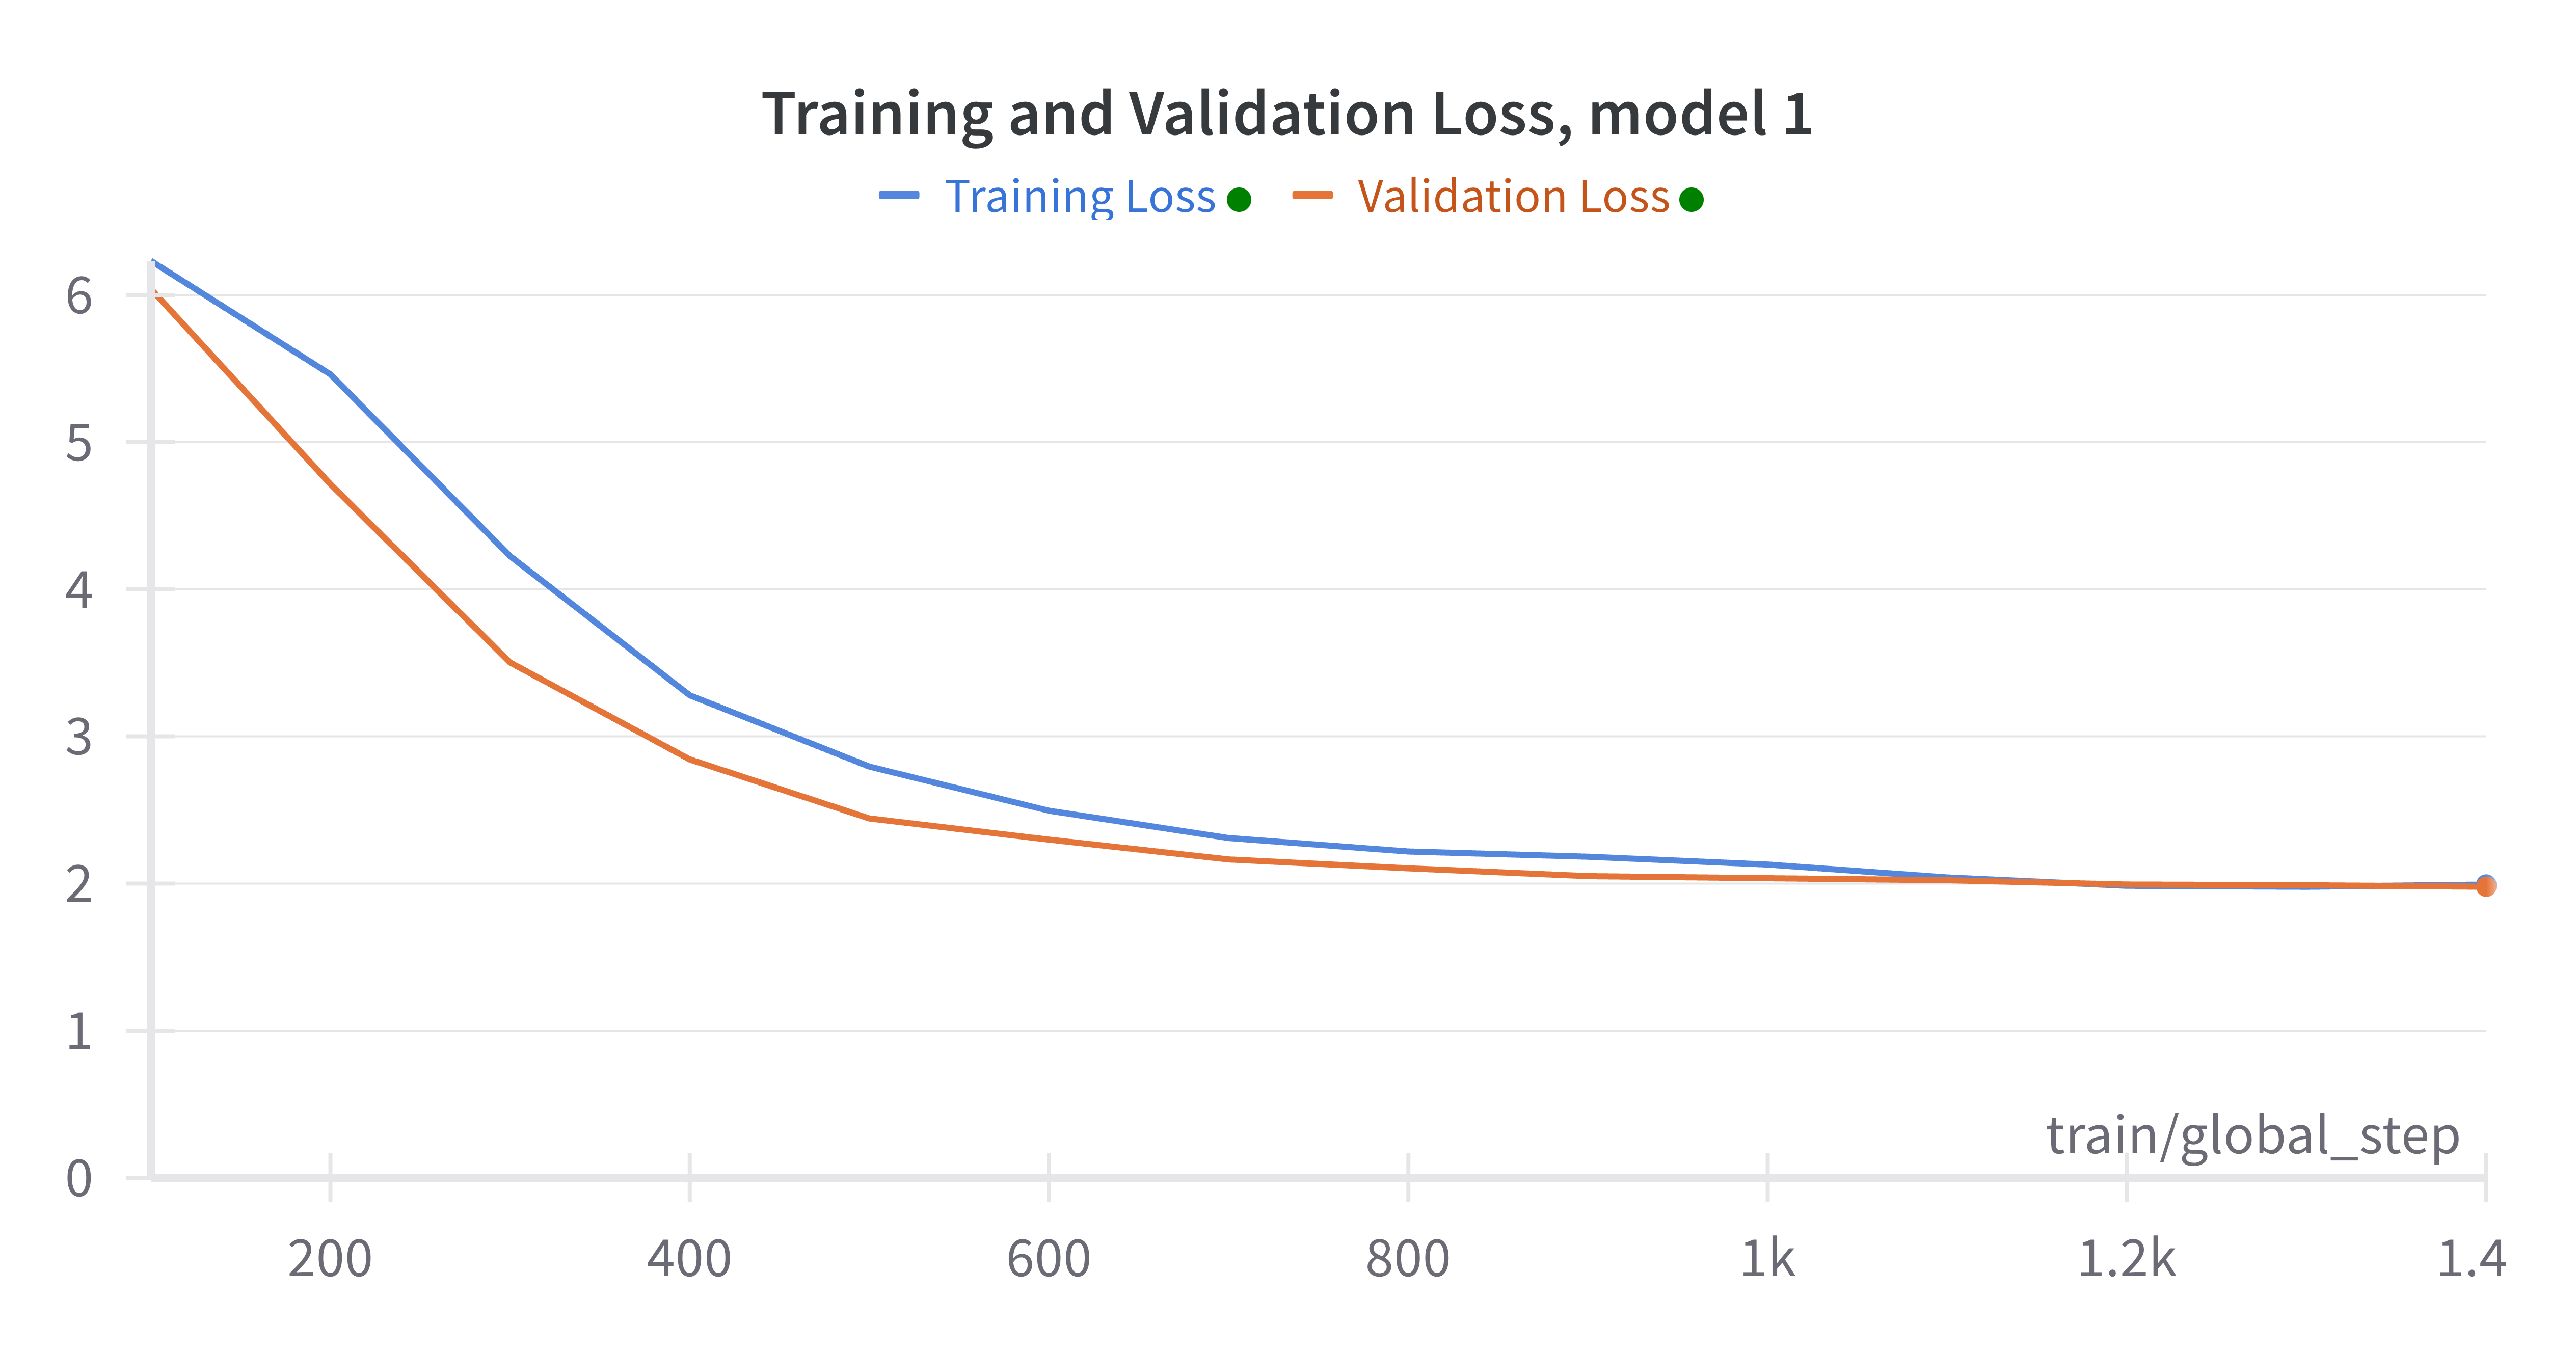

In [ ]:
# Save trained model
model1_trainer.save_model("model1")

### Inference

To see if we trained the model properly, we use the model to answer to a small portion of the questions in the test set and then compare the results with the ones that are annotated as correct.

In [ ]:
# Load the trained model
model1tr = AutoModelForQuestionAnswering.from_pretrained("model1")

# Select portion of the test set
test_set_small = newsqa["test"].select(range(6))

# Get predictions
test_pred_ans = test_set_small.map(lambda sample:
                                   get_answer_map(sample,
                                                  model1tr,
                                                  model1_tokenizer))

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [ ]:
# Store the predictions in a pandas dataframe
test_ans1 = pd.DataFrame(test_pred_ans)

# Select only the columns to show
to_show = ["story_text", "question", "theor_answers", "predicted_answer"]
test_ans1 = test_ans1[to_show]

test_ans1

,story_text,question,theor_answers,predicted_answer
0,-LRB- CNN -RRB- -- NASA wo n't have to maneuve...,What was the space station crew forced to take...,a piece of debris,"its escape capsule,"
1,-LRB- CNN -RRB- -- The partnership started as ...,Where did Lewis Partnership begin ?,The partnership started as a single shop on Ox...,"Oxford Street in London,"
2,NEW YORK -LRB- CNN -RRB- -- Cool suit ? Check ...,What does Gary Go use for musical accompaniment ?,iPhone apps,iPhone apps to
3,-LRB- CNN -RRB- -- Speculation about the futur...,What will American Airline will operate ?,normal flight schedules during the bankruptcy ...,normal flight schedules during
4,"LAGOS , Nigeria -LRB- CNN -RRB- -- Royal Dutch...",How many of Shell 's pipeliens were attacked ?,two of,two of
5,"-LRB- CNN -RRB- -- Packing winds of 140 mph , ...",What is the current strength of the winds ?,140 mph,"140 mph,"


What can be seen from this 5 answers is that in some cases the model retrieves the exact answer almost as a total match (rows 2, 4, 5), while it gives a more strigthforward (and still meaningful) answer in row 1. On the other hand, as we could expect, we can see that the model doesn't retrieve correctly all the answers as we can see in row 0. 

## Model 2 - google-bert/bert-base-cased

### Data preprocessing and data loading

As done for the previous model, we need load the model and preprocess the data to train the second model.

In [ ]:
# Load original model and tokenizer
hf_modelname2 = "google-bert/bert-base-cased"
model2 = AutoModelForQuestionAnswering.from_pretrained(hf_modelname2)
model2_tokenizer = AutoTokenizer.from_pretrained(hf_modelname2)

# Setup LoRA configuration
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules= ["query", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type="QUESTION_ANS"
)

# Lora Model with given configuration
model2 = get_peft_model(model2, config)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train and validation data preprocessing
train_data_preprocessed2 = newsqa["train"].map(lambda sample:
                                               preproc_map(sample,
                                                           model2_tokenizer))

val_data_preprocessed2 = newsqa["validation"].map(lambda sample:
                                                  preproc_map(sample,
                                                              model2_tokenizer))

Map:   0%|          | 0/34519 [00:00<?, ? examples/s]

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

### Training

As for the previous model, these are the hyperparameters that gave the best validation loss.

In [ ]:
args_model2 = TrainingArguments(
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 4,
        warmup_steps = 500,
        learning_rate = 1e-3,
        fp16=True,
        logging_steps= 100,
        eval_strategy = "steps",
        output_dir="model2_final",
        save_steps = 100,
        report_to="wandb",
        load_best_model_at_end = True
    )

model2_trainer = Trainer(
    model=model2,
    train_dataset = train_data_preprocessed2,
    eval_dataset = val_data_preprocessed2,
    args = args_model2,
    tokenizer = model2_tokenizer,
    data_collator = DataCollatorWithPadding(model2_tokenizer)
)

model2.config.use_cache = False
model2_trainer.train()


Step,Training Loss,Validation Loss
100,5.826700,4.782746
200,4.363900,3.593400
300,3.358300,2.680926
400,2.746700,2.449369
500,2.550600,2.300187
600,2.392300,2.253217
700,2.257800,2.123325
800,2.192500,2.076426
900,2.142200,2.018776
1000,2.124000,1.993820


TrainOutput(global_step=1617, training_loss=2.574042477722734, metrics={'train_runtime': 2576.9487, 'train_samples_per_second': 40.186, 'train_steps_per_second': 0.627, 'total_flos': 2.72236549774464e+16, 'train_loss': 2.574042477722734, 'epoch': 2.9972196478220576})

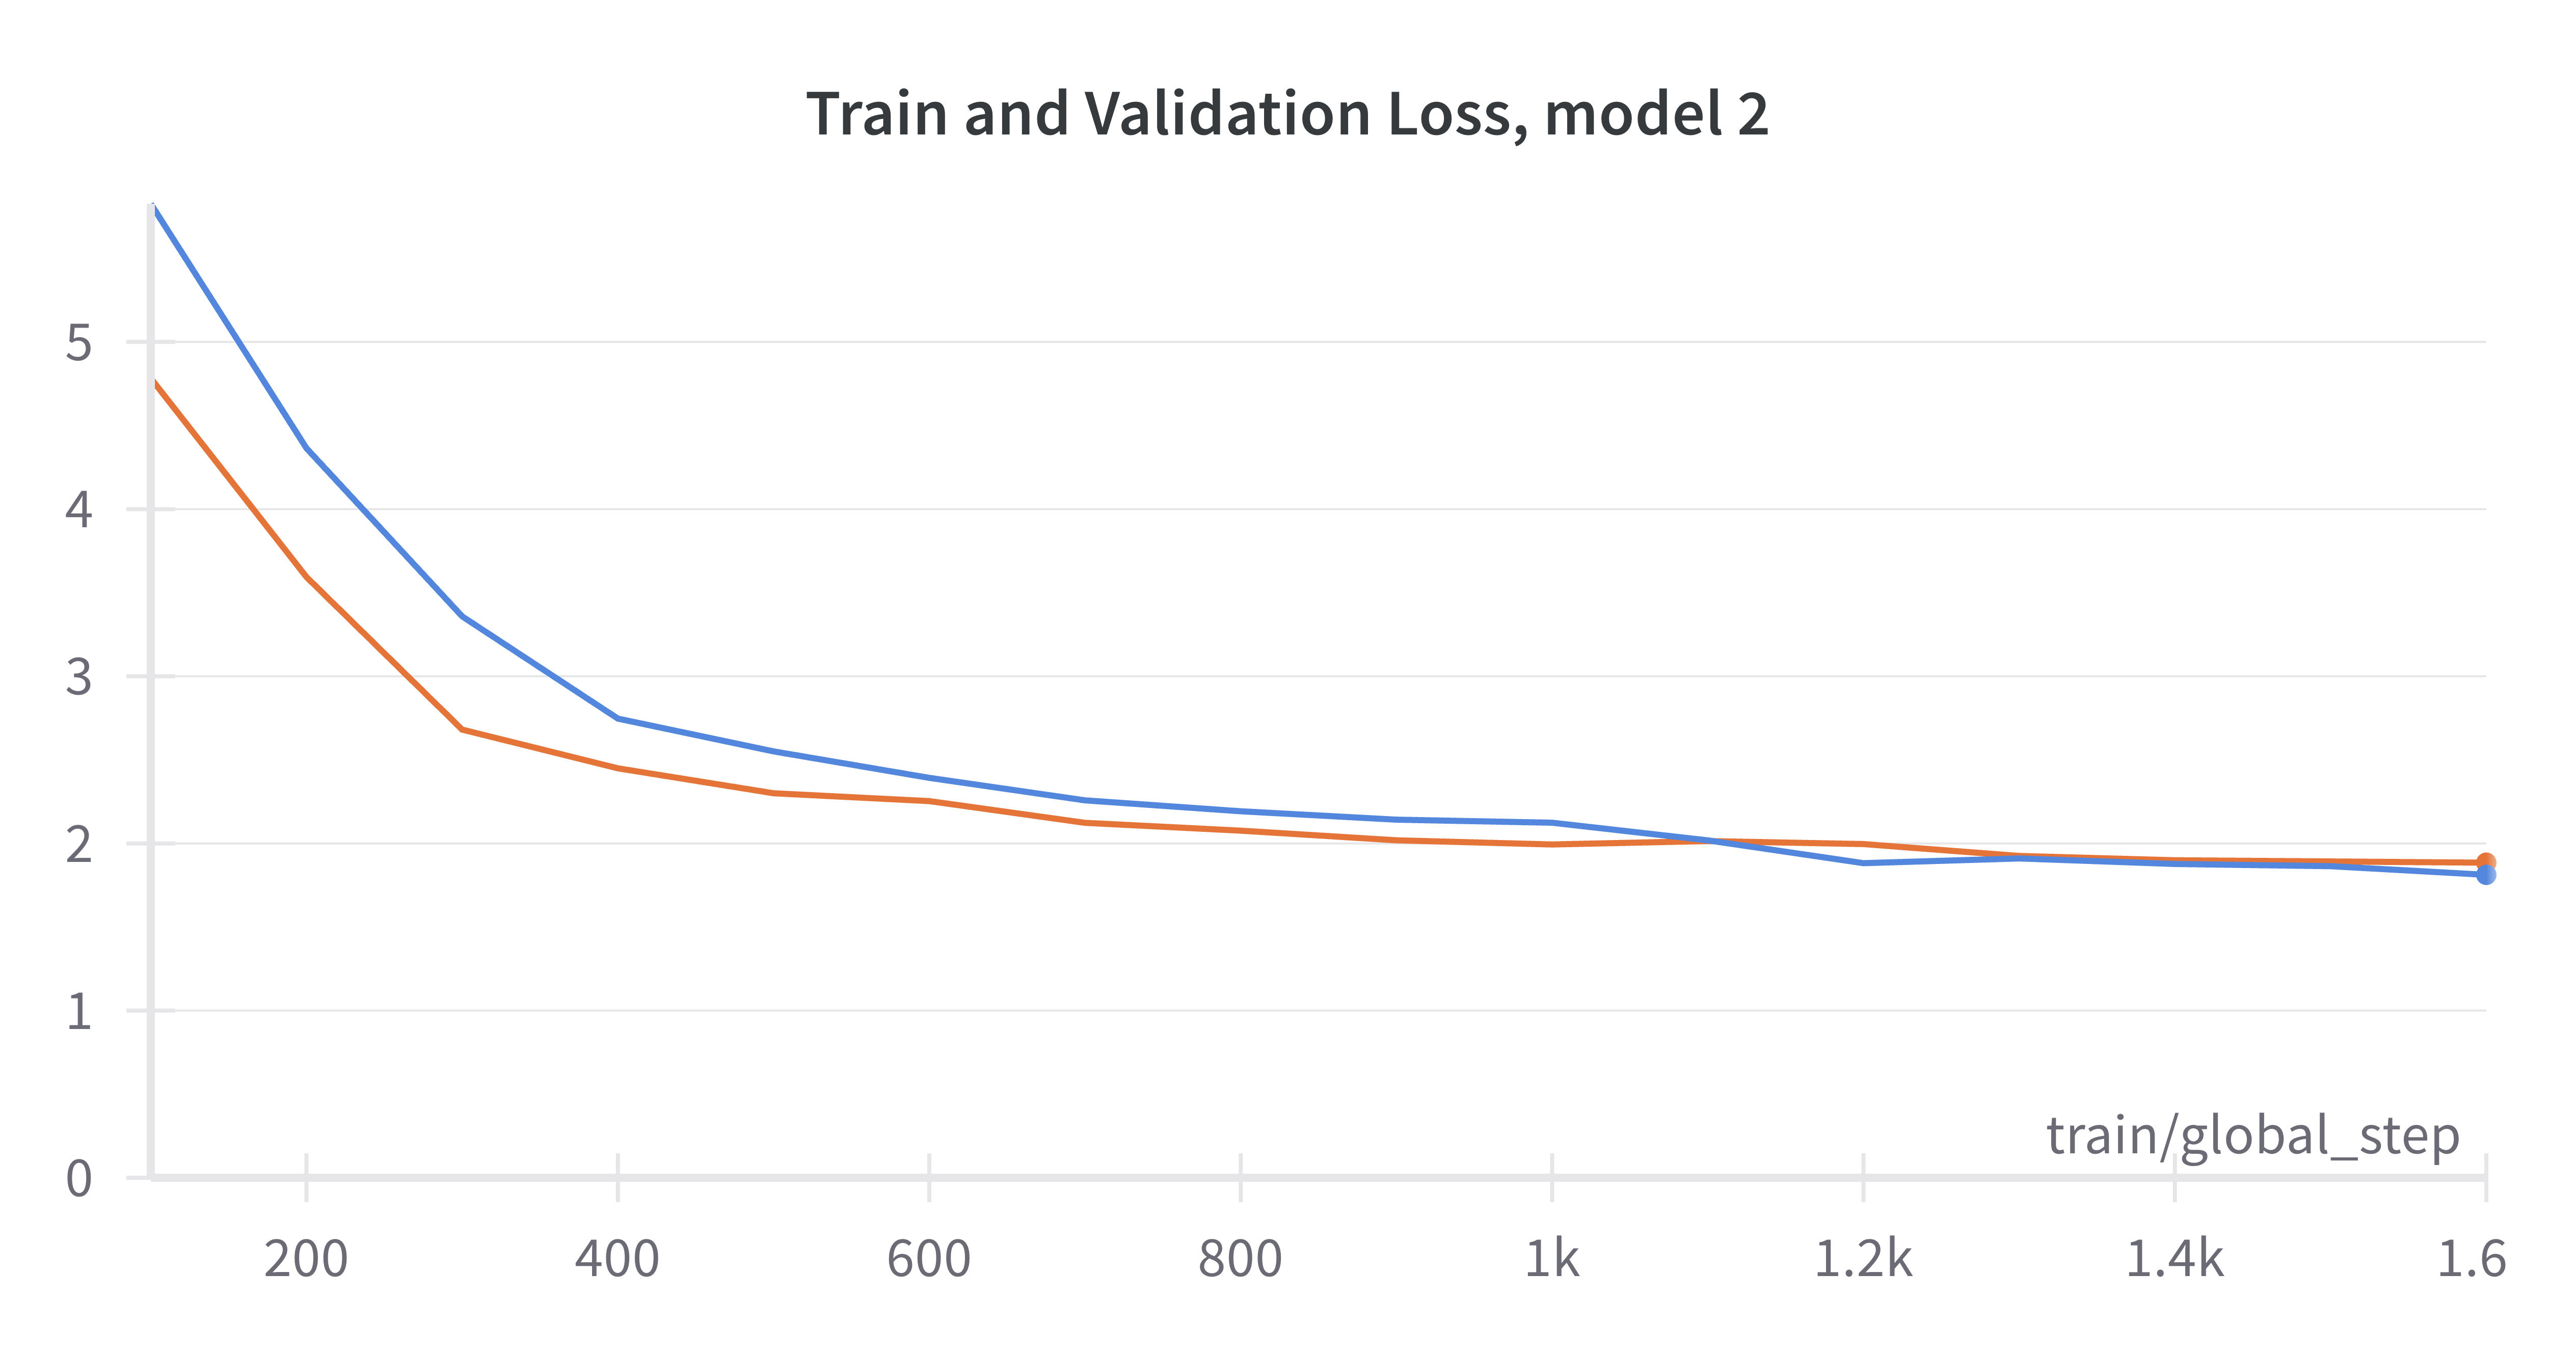

In [ ]:
# Save model and weigths
model2_trainer.save_model("model2")
torch.save(model2.state_dict(), 'model2_lora_weights.pth')

### Inference

Also for this model, we decided to predict the answer on a subset test set, store them in a dataframe and compare them with the correct ones. The subset is the same as the one used in the first model.

In [ ]:
# Load model after training
model2tr = AutoModelForQuestionAnswering.from_pretrained("model2")
model2tr = PeftModel(model2tr, config)

lora_weights = torch.load('model2_lora_weights.pth')
model2tr.load_state_dict(lora_weights, strict=False)

# Select portion of the test set
test_set_small = newsqa["test"].select(range(6))

# Get predicted answer on the test set
test_pred_ans2 = test_set_small.map(lambda sample:
                                    get_answer_map(sample,
                                                   model2tr,
                                                   model2_tokenizer))


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [ ]:
# Store predicted answers in a dataframe
test_ans2 = pd.DataFrame(test_pred_ans2)
to_show = ["story_text", "question", "theor_answers", "predicted_answer"]
test_ans2 = test_ans2[to_show]
test_ans2

,story_text,question,theor_answers,predicted_answer
0,-LRB- CNN -RRB- -- NASA wo n't have to maneuve...,What was the space station crew forced to take...,a piece of debris,
1,-LRB- CNN -RRB- -- The partnership started as ...,Where did Lewis Partnership begin ?,The partnership started as a single shop on Ox...,"Oxford Street in London,"
2,NEW YORK -LRB- CNN -RRB- -- Cool suit ? Check ...,What does Gary Go use for musical accompaniment ?,iPhone apps,iPhone apps to
3,-LRB- CNN -RRB- -- Speculation about the futur...,What will American Airline will operate ?,normal flight schedules during the bankruptcy ...,normal flight schedules during
4,"LAGOS , Nigeria -LRB- CNN -RRB- -- Royal Dutch...",How many of Shell 's pipeliens were attacked ?,two of,two of
5,"-LRB- CNN -RRB- -- Packing winds of 140 mph , ...",What is the current strength of the winds ?,140 mph,"140 mph,"


We have the same situation as the previous model, except for the first answer, that in this case is detected as missing.

## Task 2.2 - Theory

1. You have an LLM that generates text and you want to generate the word Ferrari within a sentence. How can
you do this? Answer on both practical and theoretical aspects.
2. How might biases in training data affect the output of LLMs, and what strategies can be employed to mitigate
these biases?

1. Since LLMs generate text by predicting the next word in a sequence based on the previous context, the probability of generating "Ferrari" is influenced by the context provided in the prompt. Thus we can either provide the model a sentence that naturally leads to the word "Ferrari" or a sentence that logically concludes with the word "Ferrari" in order to increase the condiitonal probablity of this word, and select words using a decoding strategy (Greedy search, Beam search, Top-K sampling and Top-p sampling). Indeed, by passing this prompt "*The famous Italian luxury sports car manufacturer based in Maranello is called*" to the model created in the lab and using beam search and top-K sampling, we got the following results:
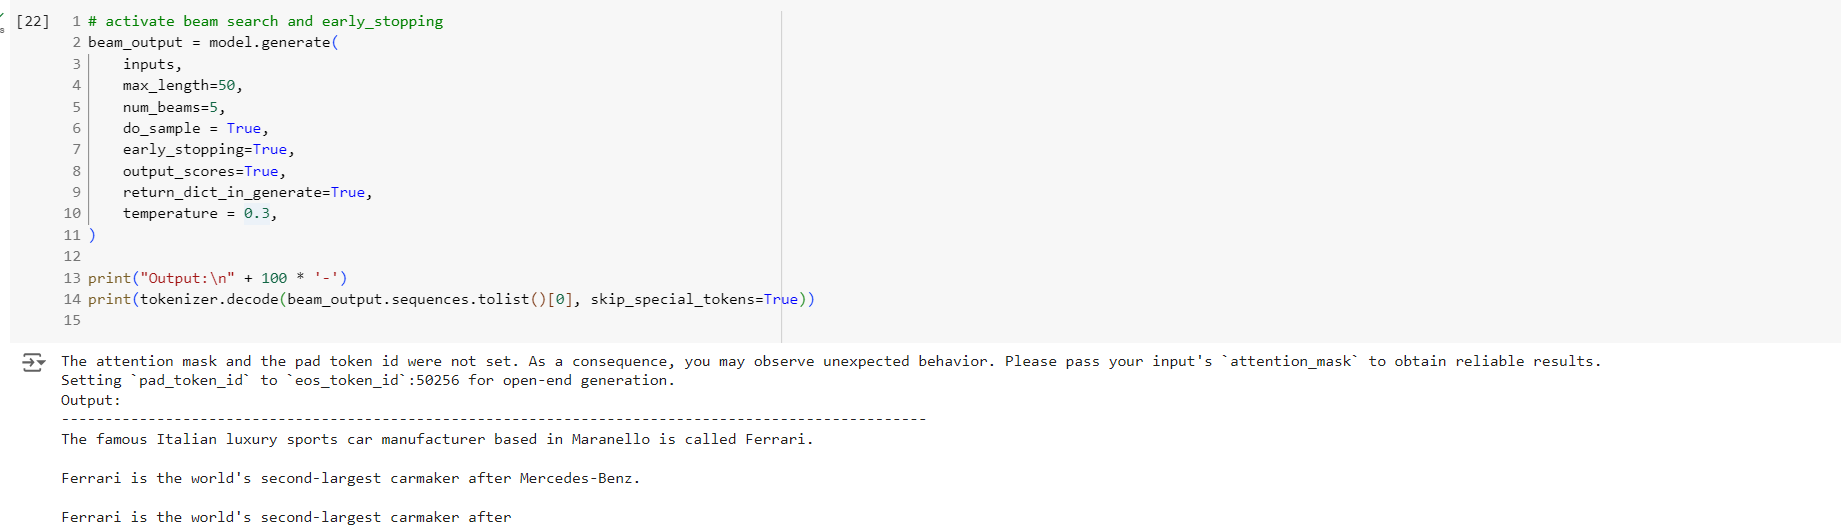

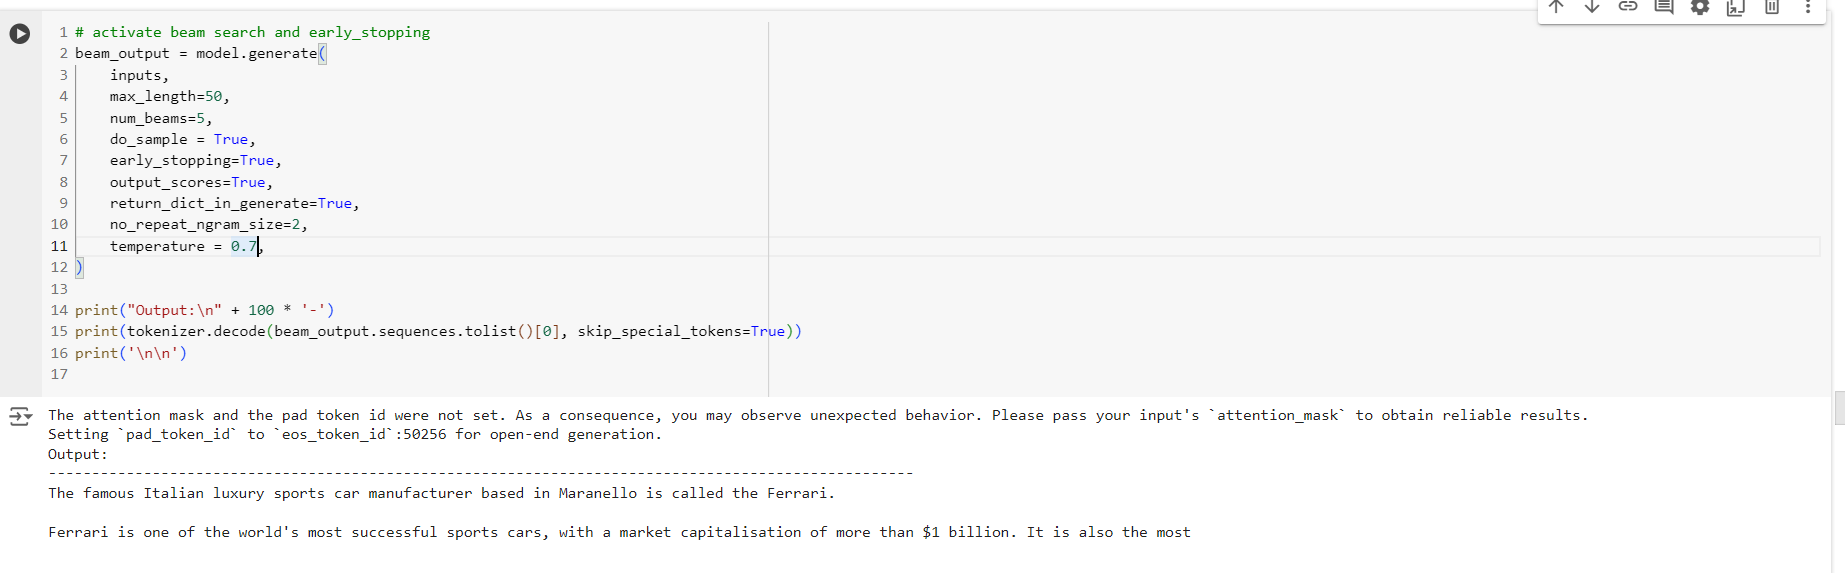

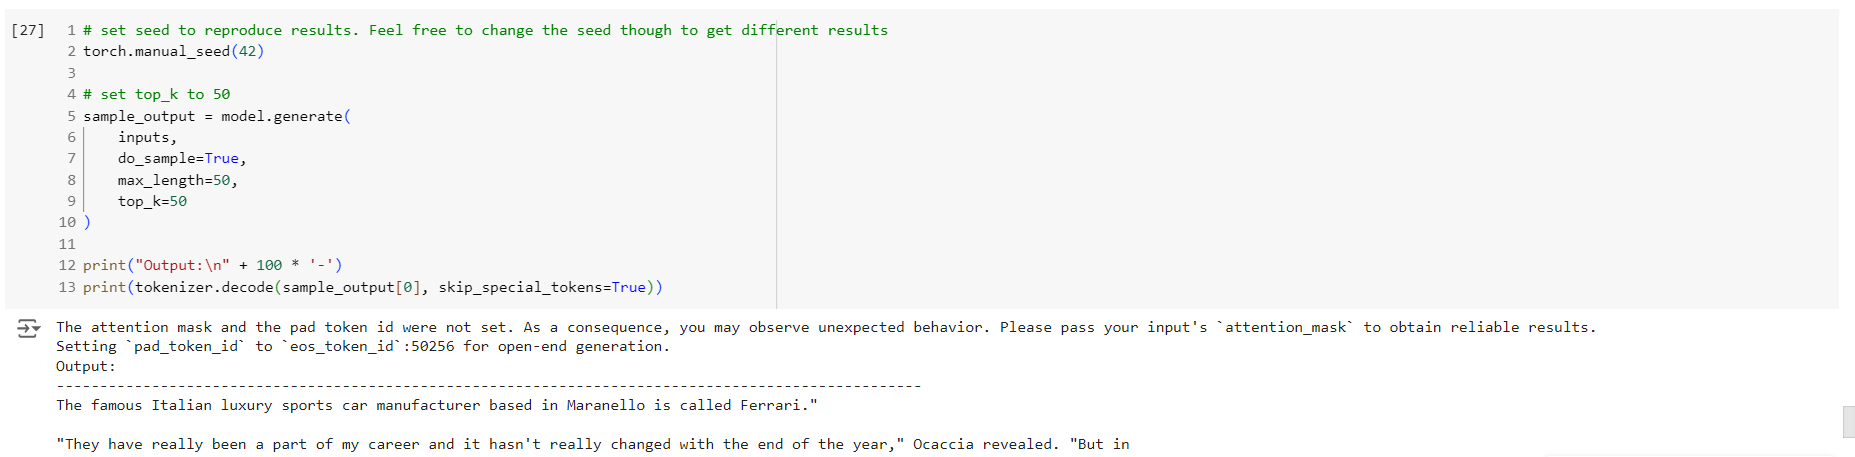

2. Biases in training data can affect the LLM by pushing it to learn incorrect conditional probablilty distributions of the tokens, thus leading to mistakes (that can vary from grammar errors to wrong answers or even spread of misinformation and stereotypes) in the inference phase. To mitigate these biases one can try to ensure the dataset is balanced for example by removing explicitly biased content or trying to augment underepresented categories of data. Another approach is fine tuning it using an instruction step plus an RLHF step, which is shown to enhance the accuracy and reliability of AI interactions

# Task 3

1. Discuss the potential advantages of using RAG over purely generative models. In what scenarios might RAG
provide significant benefits?

2. Can RAG models handle cases where the needed information is very rare or not present in the training data?

3. Which are some improvements over plain RAG that could potentially enhance its performance or applicability?

1. The advantages of RAG over purely generative models are several as they combine the information retrieval approach with text generation, thus allowing it to access updated information sources as well as specific sources on a certain topic withoout requiring a re-training or fine-tuning (which are very expansive in terms of time and resources). This could lead to less hallucinations and more updated and accurate results, making these models particularly useful in Knowledge-Intensive tasks like open-domain question answering, fact checking, entity linking. Thus they could provide singificant benefits in knowledge intensive and rapidly evolving scenarios requiring
real-time knowledge updates and external information (e.g. verifying wikipedia's claims and suggesting citations).

2. Yes, RAG models are particularly good at handling cases where the information is rare or not present in the training data and they do this by retrieving the relevant documents from an external corpus directly during inference. Indeed, they can retrieve chunks from an external knowledge base using vector search and them pass these as a prompt to the LLM, which allows the model to incorporate external knowledge that was even totally absent in the training data. Thanks to this technique they can generate accurate responses, where "classical" models would have had hallucinations.

3. To enhance the performance of plain RAG we can do both pre-retrieval and post-retrieval operations. Examples of the first kind of operations are expand and/or rewrite the query before feeding it to the retrieval, while for the second section we can select only relevant documents, re-rerank them and compress them before creating the prompts. Another possibility is the BGM framework, which consists in putting a trainable "bridge model" between the retriever and LLM (that are kept fixed) that aims to transform the retrieved data into a format which yelds better performance for the LLM.